<a href="https://colab.research.google.com/github/sonalisanjeevprabu18/Neural-Network-and-Deep-Learning/blob/main/MNIST_2DdigitURL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.8370 - loss: 0.6405
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9551 - loss: 0.1620
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9746 - loss: 0.0949
Epoch 1/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7584 - loss: 0.6067
Epoch 2/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0163
Epoch 3/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 4/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 5/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 6/6
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0019
F1 on 2000-test-samples: 0.1271
Final prediction: 37


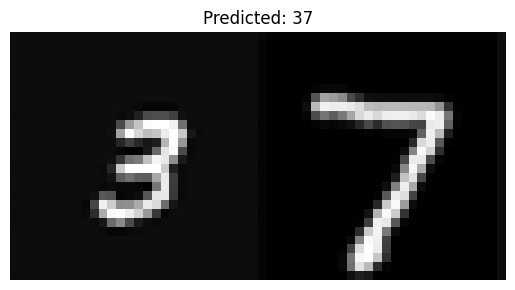

In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28,28,1).astype('float32')/255.0
x_test  = x_test.reshape(-1,28,28,1).astype('float32')/255.0
y_train_oh = tf.keras.utils.to_categorical(y_train,10)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_oh, epochs=3, batch_size=128, verbose=1)

def prepare(path):
    im = Image.open(path).convert("L").resize((28,28))
    im = ImageOps.autocontrast(im)
    arr = np.array(im).astype('float32')/255.0
    if arr.mean()>0.5:
        im = ImageOps.invert(im)
        arr = np.array(im).astype('float32')/255.0
    mask = arr>0.05
    if mask.sum():
        coords = np.argwhere(mask)
        r_mean,c_mean = coords.mean(axis=0)
        r_shift = int(round(arr.shape[0]/2 - r_mean))
        c_shift = int(round(arr.shape[1]/2 - c_mean))
        arr = np.roll(arr, r_shift, axis=0)
        arr = np.roll(arr, c_shift, axis=1)
    return arr.reshape(28,28,1)

p1="/content/digit3jpg.jpg"
p2="/content/digit7.webp"
a1 = prepare(p1)
a2 = prepare(p2)

user_x = np.vstack([a1[np.newaxis,...], a2[np.newaxis,...]])
user_y = np.array([3,7])
user_y_oh = tf.keras.utils.to_categorical(user_y,10)

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.12, height_shift_range=0.12, zoom_range=0.08)
batch = datagen.flow(user_x, user_y_oh, batch_size=2, shuffle=True, seed=1)
aug_count = 200
X_aug = []
Y_aug = []
for _ in range(aug_count//2):
    xb, yb = next(batch)
    X_aug.append(xb); Y_aug.append(yb)
X_aug = np.vstack(X_aug); Y_aug = np.vstack(Y_aug)

model.fit(X_aug, Y_aug, epochs=6, batch_size=16, verbose=1)

y_pred_test = np.argmax(model.predict(x_test[:2000], verbose=0), axis=1)
f1 = f1_score(y_test[:2000], y_pred_test, average='macro')
print(f"F1 on 2000-test-samples: {f1:.4f}")

pl = int(np.argmax(model.predict(a1.reshape(1,28,28,1), verbose=0)[0]))
pr = int(np.argmax(model.predict(a2.reshape(1,28,28,1), verbose=0)[0]))
print("Final prediction:", f"{pl}{pr}")

combined = np.hstack((a1.reshape(28,28), a2.reshape(28,28)))
plt.imshow(combined, cmap='gray'); plt.title(f"Predicted: {pl}{pr}"); plt.axis('off'); plt.show()
